In [13]:
# Define all applicable imports
import pandas as pd
import xarray as xr
import sqlite3
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import calendar


In [14]:
# Define notable variables
# Define the range of full years of data availabe in the Earthdata base_path
start_year = 2015
end_year = 2016
base_path = '../input/earthdata-ges-disc/dataset'


In [15]:
def generate_dates(start_year, end_year):
    """Generates a list of dates from start_year to end_year."""
    start_date = pd.Timestamp(f'{start_year}-01-01')
    end_date = pd.Timestamp(f'{end_year}-12-31')
    return pd.date_range(start=start_date, end=end_date, freq='D')

dates = generate_dates(start_year, end_year)


In [16]:
def process_nc_files(base_path):
    """Loads and processes .nc4 files into a single DataFrame."""
    all_data = []
    
    for date in dates:
        formatted_date = date.strftime('%Y%m%d')
        file_path = f'{base_path}/3B-DAY-L.MS.MRG.3IMERG.{formatted_date}-S000000-E235959.V06.nc4.SUB.nc4'
        ds = None  # Initialize ds to None

        try:
            ds = xr.open_dataset(file_path)
            # Assuming 'precipitation' is the variable name; replace as needed
            daily_precip_in_mm = ds['precipitationCal'].mean().values
            all_data.append({'date': date, 'precipitation': daily_precip_in_mm})
        except FileNotFoundError:
            print(f"File not found: {file_path}")
        except ValueError as e:
            print(f"Error opening file: {file_path}. Error: {e}")
        finally:
            if ds:
                ds.close()

    return pd.DataFrame(all_data)

df_precipitation = process_nc_files(start_year, end_year, base_path)


In [17]:
# Extract water levels data
# Connect to the SQLite DB
conn = sqlite3.connect('../input/hydat-db/Hydat.sqlite3')

# Define relevant station numbers
relevant_station_numbers_query = """
SELECT STATION_NUMBER
FROM STATIONS
WHERE CONTRIBUTOR_ID = 75 AND HYD_STATUS = 'A'
AND LONGITUDE BETWEEN -131.941 AND -112.897
AND LATITUDE BETWEEN 47.126 AND 57.367;
"""

relevant_station_numbers = pd.read_sql_query(relevant_station_numbers_query, conn)
list_of_relevant_station_numbers = relevant_station_numbers['STATION_NUMBER'].tolist()


# Convert list of station numbers to a format that can be used in SQL query
station_numbers_tuple = tuple(list_of_relevant_station_numbers)

# Fetch water level data for each day of the month for BC Hydro stations
day_columns = [f"LEVEL{i}" for i in range(1, 32)]  # LEVEL1, LEVEL2, ..., LEVEL31
day_columns_str = ', '.join(day_columns)
query = f"""
SELECT STATION_NUMBER, YEAR, MONTH, NO_DAYS, FULL_MONTH, {day_columns_str}
FROM DLY_LEVELS
WHERE STATION_NUMBER IN ({','.join('?' for _ in station_numbers_tuple)})
"""

df_water_levels = pd.read_sql_query(query, conn, params=station_numbers_tuple)

# Close the connection
conn.close()


In [18]:

# Pre-process water levels data

# Define the function to calculate the monthly mean water level
def calculate_monthly_mean(water_levels, overall_mean):
    # If there are missing days, use mean imputation
    if water_levels.isna().any():
        water_levels.fillna(overall_mean, inplace=True)
    
    # Calculate the mean of daily levels
    return water_levels.mean()

# Melt df_water_levels to create a long-form DataFrame
df_water_levels_long = pd.melt(df_water_levels, 
                               id_vars=['STATION_NUMBER', 'YEAR', 'MONTH'],
                               value_vars=[f'LEVEL{i}' for i in range(1, 32)],
                               var_name='DAY', value_name='WATER_LEVEL')

# Extract day number and convert to integer
df_water_levels_long['DAY'] = df_water_levels_long['DAY'].str.extract(r'(\d+)').astype(int)

# Filter out invalid days for each month
df_water_levels_long = df_water_levels_long[df_water_levels_long.apply(lambda x: x['DAY'] <= calendar.monthrange(x['YEAR'], x['MONTH'])[1], axis=1)]

# Convert 'YEAR', 'MONTH', and 'DAY' to a single 'date' column
df_water_levels_long['date'] = pd.to_datetime(df_water_levels_long[['YEAR', 'MONTH', 'DAY']])

# Drop unnecessary columns
df_water_levels_long.drop(columns=['YEAR', 'MONTH', 'DAY'], inplace=True)

# Calculate the overall mean from all available daily data
all_daily_levels = df_water_levels_long['WATER_LEVEL'].dropna().tolist()
overall_mean = np.mean(all_daily_levels)

# Apply the function to calculate the monthly mean water level
df_water_levels_long['calculated_monthly_mean'] = df_water_levels_long.groupby(['STATION_NUMBER', 'date'])['WATER_LEVEL'].transform(lambda x: calculate_monthly_mean(x, overall_mean))


In [19]:
# Merge water levels and precipitation data by left join on date
df_combined = pd.merge(df_precipitation, df_water_levels_long, on='date', how='left')


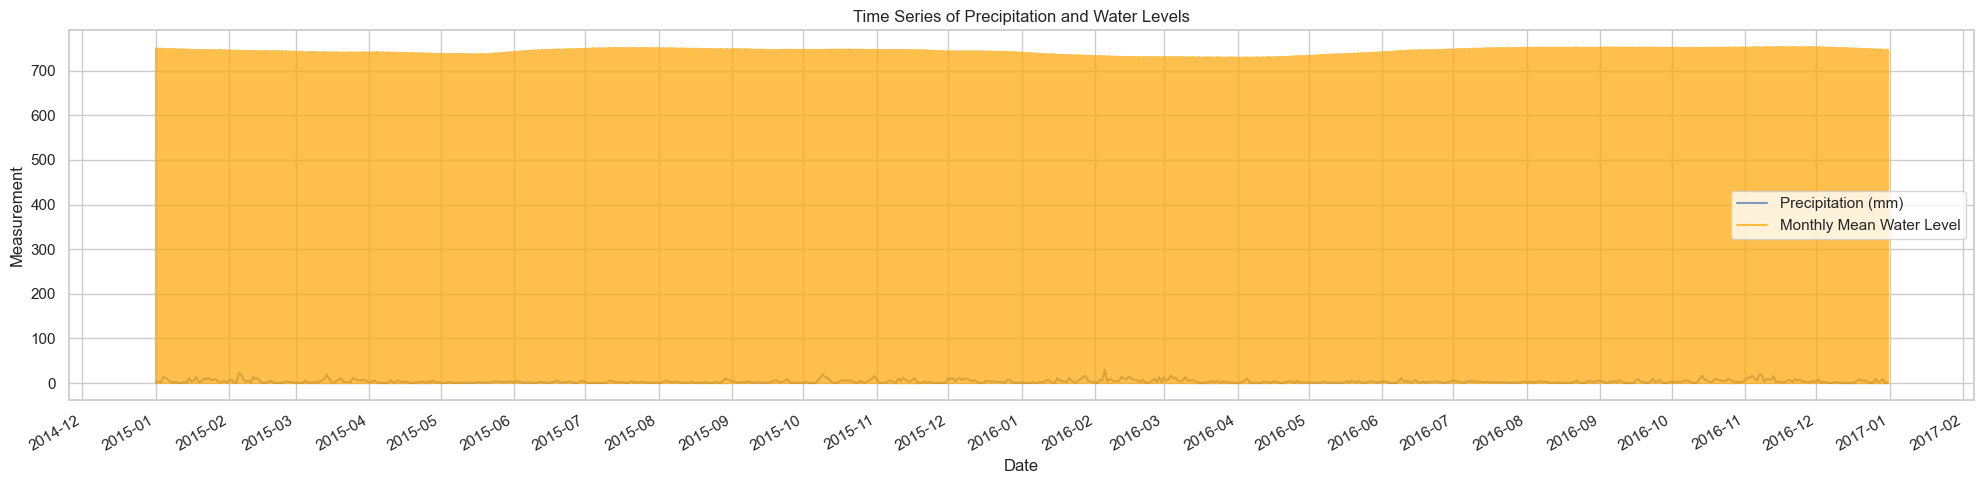

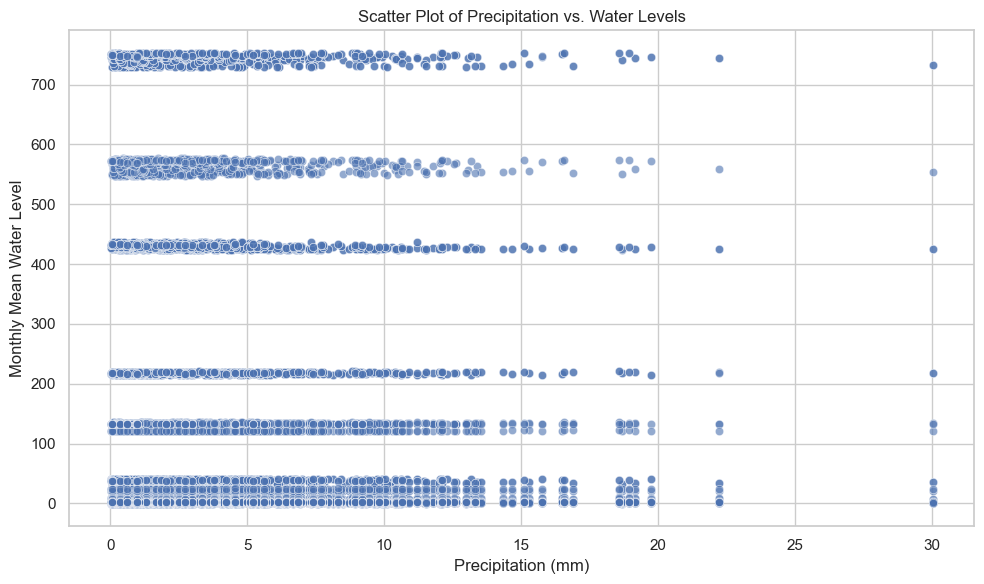

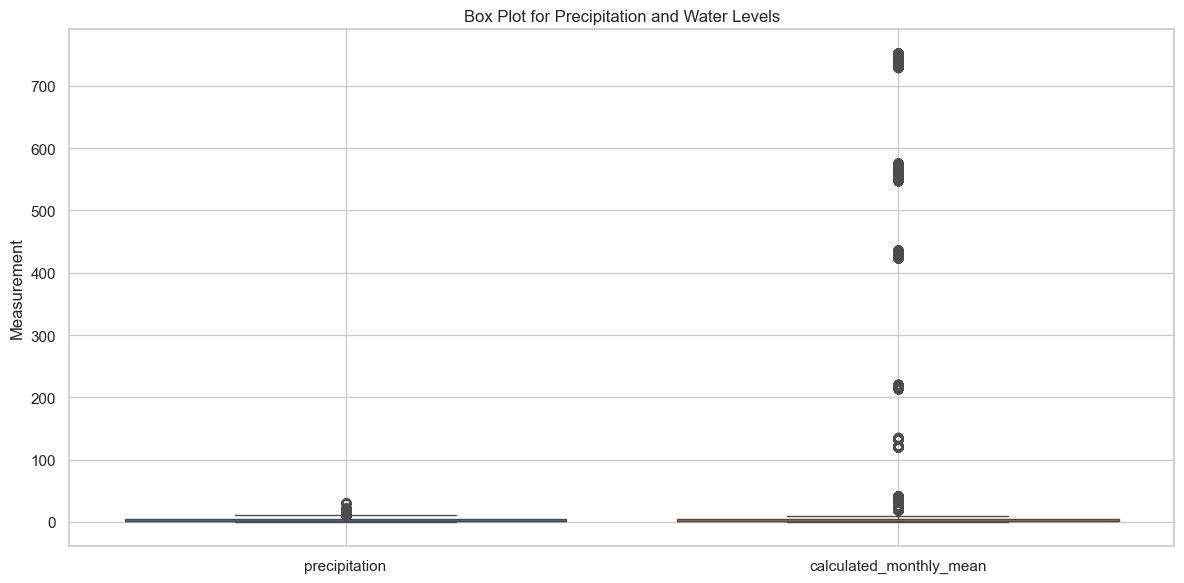

In [20]:
# Visualization

%matplotlib inline

# Convert 'precipitation' to float
df_combined['precipitation'] = df_combined['precipitation'].astype(float)

# Ensure 'calculated_monthly_mean' is also a float
df_combined['calculated_monthly_mean'] = df_combined['calculated_monthly_mean'].astype(float)

# Set the aesthetics for the plots
sns.set(style="whitegrid")

# Time Series Plot for Precipitation and Water Levels
# Set the figure size and the aspect ratio to give more space on the x-axis
plt.figure(figsize=(20, 5))

# Plot the time series data
plt.plot(df_combined['date'], df_combined['precipitation'], label='Precipitation (mm)', alpha=0.7)
plt.plot(df_combined['date'], df_combined['calculated_monthly_mean'], label='Monthly Mean Water Level', color='orange', alpha=0.7)

# Set major ticks to be at the first of each month and format them to show the month and year
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# Rotate and align the tick labels so they look better
plt.gcf().autofmt_xdate()

# Add labels, title, and legend
plt.xlabel('Date')
plt.ylabel('Measurement')
plt.title('Time Series of Precipitation and Water Levels')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Scatter Plot for Precipitation vs. Water Levels
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_combined, x='precipitation', y='calculated_monthly_mean', alpha=0.6)
plt.xlabel('Precipitation (mm)')
plt.ylabel('Monthly Mean Water Level')
plt.title('Scatter Plot of Precipitation vs. Water Levels')
plt.grid(True)
plt.tight_layout()
plt.show()

# Box Plot for Precipitation and Water Levels
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_combined[['precipitation', 'calculated_monthly_mean']])
plt.ylabel('Measurement')
plt.title('Box Plot for Precipitation and Water Levels')
plt.grid(True)
plt.tight_layout()
plt.show()
